In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.32.3
BeautifulSoup   4.12.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


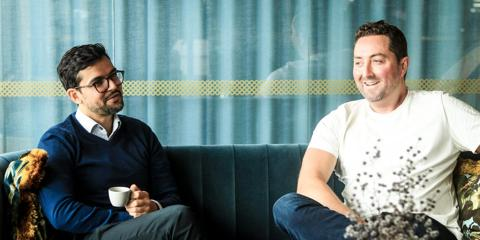

[Deckmatch uses AI to help investors find deals](https://www.businessinsider.com/deckmatch-pitch-deck-seed-funding-private-market-ai-2024-11) - Business Insider

___

[Enterprise tech leaders prep for Trump 2.0](https://www.wsj.com/articles/from-ai-to-hardware-costs-enterprise-tech-leaders-prepare-for-trump-2-0-18a5486c)

___

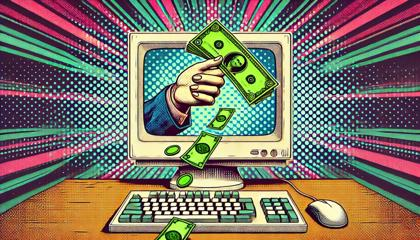

[Also some free API credits with recently added OpenAI-compliant API](https://venturebeat.com/ai/xai-woos-developers-with-25-month-worth-of-api-credits-support-for-openai-anthropic-sdks/) - VentureBeat

___

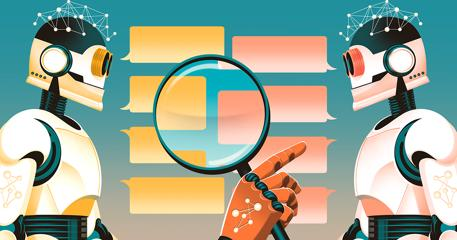

[Letting AIs debate with each other to find the truth](https://www.quantamagazine.org/debate-may-help-ai-models-converge-on-truth-20241108/?ref=hackernoon.com) - Quanta Magazine

___

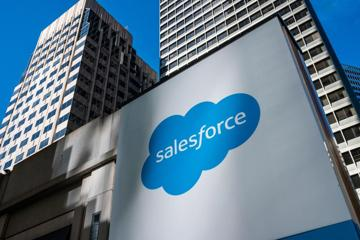

[Salesforce hires 1000 salespeople to sell AgentForce.](https://finance.yahoo.com/news/salesforce-hire-1-000-people-194931457.html) - Yahoo Finance

___

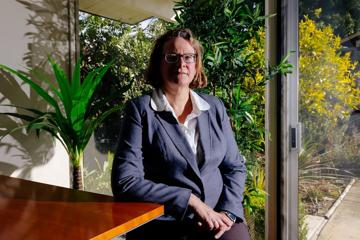

[An interview where she talks about AI](https://english.elpais.com/science-tech/2024-04-26/elisabeth-bik-expert-in-scientific-integrity-we-need-to-slow-down-scientific-publishing.html) - EL PAÍS English

___

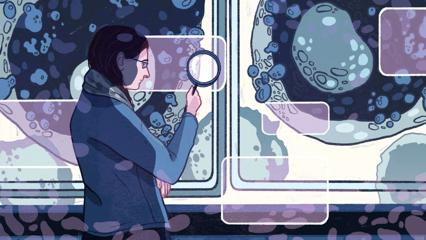

[Elisabeth Bik, scientist with an extraordinary visual memory, identified a lot of fake images by sight.](https://www.newyorker.com/science/elements/how-a-sharp-eyed-scientist-became-biologys-image-detective) - The New Yorker

___

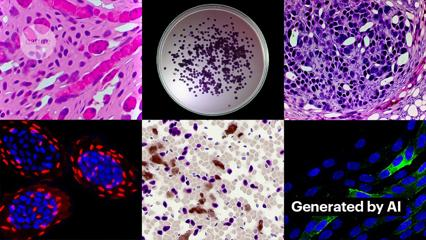

[AI is catching a lot of scientific fakery, but AI can also be put to work making very hard-to-catch fakery.](https://www.nature.com/articles/d41586-024-03542-8)

___

[Dutch publisher trials AI translations after Simon & Schuster acquisition](https://www.thebookseller.com/news/dutch-publisher-owned-by-simon-schuster-to-trial-using-ai-for-english-language-translations)

___

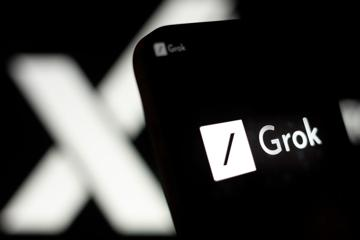

[X is trialing a free Grok chatbot with 10 queries every 2 hours in some countries.](https://techcrunch.com/2024/11/10/x-is-testing-a-free-version-of-ai-chatbot-grok/) - TechCrunch

___

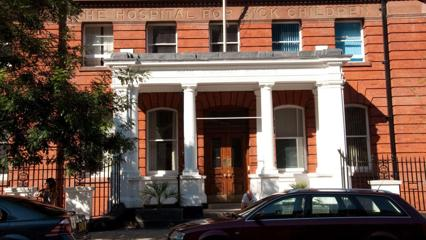

[UK's NHS trials AI note-taking for doctors.](https://uk.news.yahoo.com/nhs-doctors-could-spend-more-000100806.html) - Yahoo News

___

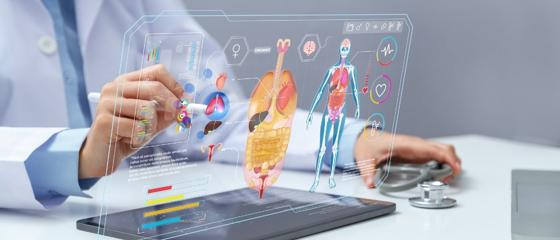

[AI enhances chronic disease management by improving early diagnosis, predicting disease progression, tracking data and recordkeeping, personalizing treatment plans based on individual patient data, with assists from smart, connected wearables, and other in-home tech.](https://hackernoon.com/how-ai-is-transforming-chronic-disease-management)

___

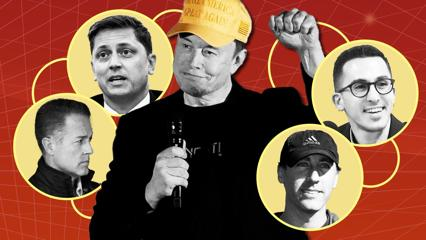

[Musk to install the guy who fired 80% of Twitter in the White House](https://www.ft.com/content/d207c4a9-0e6d-4ece-a44d-abf890316b5a)

___

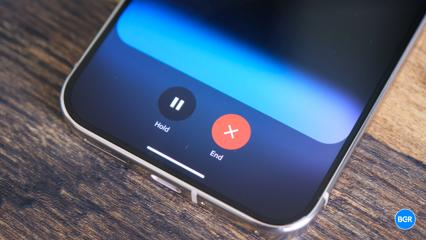

[Google's upcoming Gemini AI app for iPhone was spotted in the wild](https://bgr.com/tech/googles-upcoming-gemini-ai-app-for-iphone-was-just-uncovered/) - BGR

___

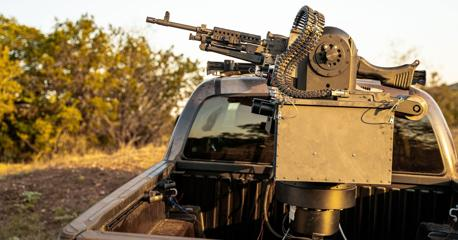

[The AI Machine Gun of the Future Is Here](https://www.wired.com/story/us-military-robot-drone-guns/) - WIRED

___

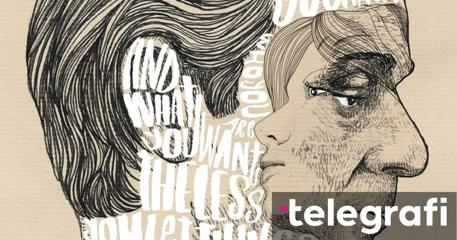

[AI might put literary translators out of work.](https://telegrafi.com/en/make-robots-our-translators-and-risk-cultural-disaster/) - Telegrafi

___

[How to fine-tune your own LLM locally or in the cloud](https://www.theregister.com/2024/11/10/llm_finetuning_guide/)

___

[A deep primer on runninng LLM models locally](https://nullprogram.com/blog/2024/11/10/)

___

[Higher electricity prices are becoming a political flashpoint.](https://www.barrons.com/articles/constellation-talen-vistra-stock-ai-nuclear-energy-acc9b5d0)

___

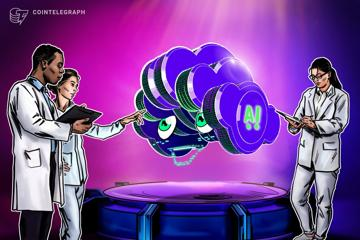

[Funding a 1.6T token model with crypto](https://cointelegraph.com/news/near-plans-to-create-world-s-largest-1-4-t-parameter-open-source-ai-model) - Cointelegraph

___

terrible AI-generated Far Side cartoons

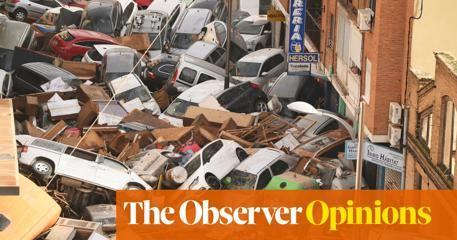

[In Spain's floods, there were bots spreading false information, and real images that were so crazy people thought they were AI
www.theguardian.com/commentisfre...](https://www.theguardian.com/commentisfree/2024/nov/09/the-images-of-spains-floods-werent-created-by-ai-the-trouble-is-people-think-they-were) - the Guardian

___

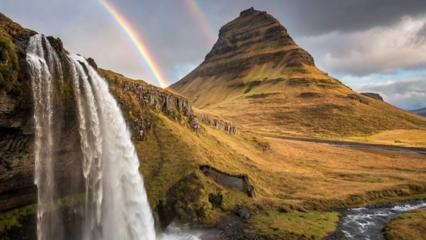

[Can Recraft usurp Midjourney as the new AI image generation leader?](https://www.tomsguide.com/ai/ai-image-video/recraft-might-be-the-most-powerful-ai-image-platform-ive-ever-used-heres-why) - Tom's Guide

___

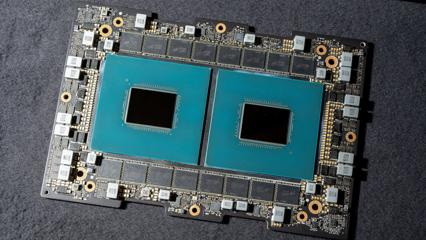

[How risky are GPU-backed loans?](https://www.ft.com/content/fb996508-c4df-4fc8-b3c0-2a638bb96c19)

___

[Cerebras inference chips run a 70b-parameter model at 2100 tokens per second.](https://www.marktechpost.com/2024/11/10/cerebras-systems-revolutionizes-ai-inference-3x-faster-with-llama-3-1-70b-at-2100-tokens-per-second/)

___

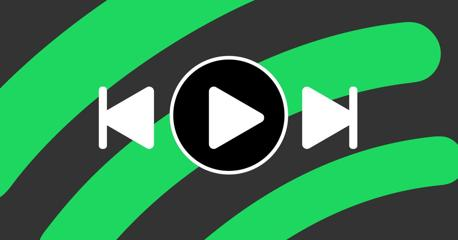

[Spotify’s AI vs a real DJ. 

I like the Spotify Discover Weekly and other AI features. I also like radioparadise.com . AI assisted discovery is cool but and so are real musicians and DJs, they aren't mutually exclusive.](https://www.theverge.com/24290914/spotify-ai-dj-radio-kexp) - The Verge

___

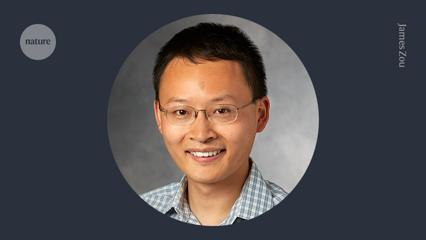

[Study estimates that 17% of peer reviews are now written with the assistance of artificial intelligence. www.nature.com/articles/d41... 
Write paper using AI, peer review it using AI, users summarize and understand it using AI](https://www.nature.com/articles/d41586-024-03588-8)

___

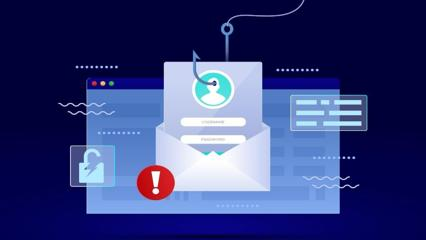

[AI-assisted phishing attacks are spiking](https://www.techradar.com/pro/phishing-attacks-surge-in-2024-as-cybercriminals-adopt-ai-tools-and-multi-channel-tactics) - TechRadar

___

[US ordered TSMC to halt shipments to China of chips used in AI applications](https://www.msn.com/en-my/news/techandscience/exclusive-us-ordered-tsmc-to-halt-shipments-to-china-of-chips-used-in-ai-applications-source-says/ar-AA1tOAAq)

___

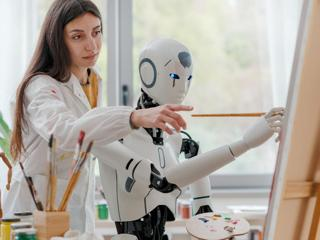

[Large Behavior Models To Create AI That Walks And Talks](https://www.forbes.com/sites/lanceeliot/2024/11/10/large-behavior-models-surpass-large-language-models-to-create-ai-that-walks-and-talks/) - Forbes

___

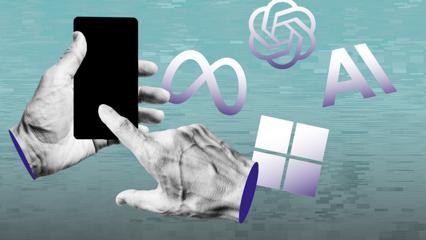

[AI's complex capabilities make benchmarks hard to design, and rapid improvement makes it hard for them to keep up.](https://www.ft.com/content/866ad6e9-f8fe-451f-9b00-cb9f638c7c59)

___

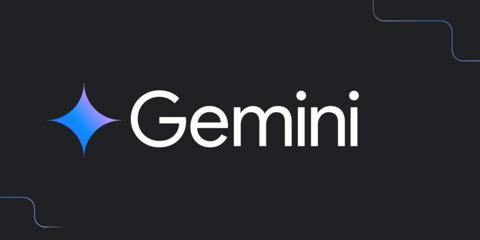

[Gemini supports the OpenAI API conventions, can be called using the Python OpenAI module.](https://developers.googleblog.com/en/gemini-is-now-accessible-from-the-openai-library/)

___

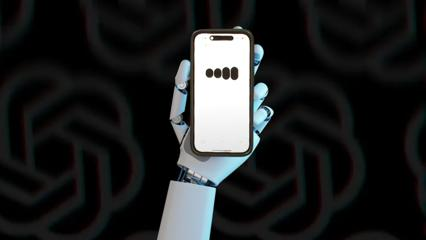

[OpenAI's Orion said to be not as large a step forward as expected.](https://techcrunch.com/2024/11/09/openai-reportedly-developing-new-strategies-to-deal-with-ai-improvement-slowdown/) - TechCrunch

___

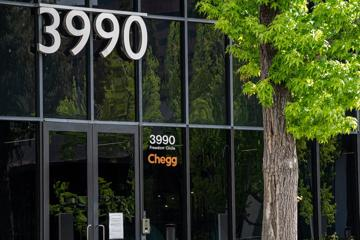

[Chegg Is On Its Last Legs After ChatGPT Sent Its Stock Down 99%](https://gizmodo.com/chegg-is-on-its-last-legs-after-chatgpt-sent-its-stock-down-99-2000522585) - Gizmodo

___

[Lilian Weng is a genius. I learned so much about stuff like reinforcement learning from her blog. I even stole her theme](https://x.com/lilianweng/status/1855031273690984623) - X (formerly Twitter)

___

[I wrote some stuff about the election. It's just the blinding glimpses of the obvious, to process it for myself.](https://druce.ai/2024/11/election2024) - Druce.ai

___

Typical Harris voter

Typical Trump voter

using recraft.ai , typical American voter

[Asking AI to make a super realistic photo of a Reddit mod](https://www.reddit.com/r/ChatGPT/comments/1gn9eu1/i_told_chatgpt_to_make_a_realistic_photo_of_a/)

___

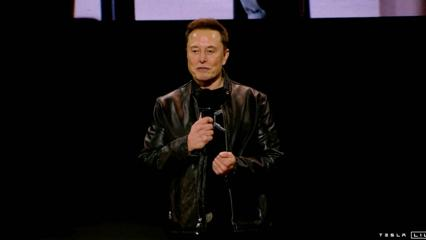

[NHTSA warns Tesla. (Musk: hahaha you have no power here)](https://www.cnbc.com/2024/11/08/tesla-social-media-posts-falsely-say-cars-are-robotaxis-nhtsa-warns.html) - CNBC

___

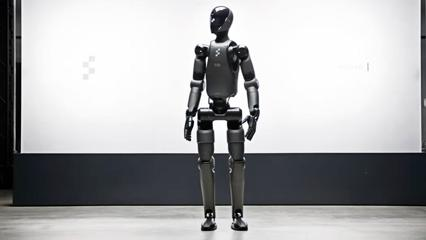

[AI and robotics reduce upward mobility by de-skilling some workers.](https://www.techradar.com/pro/ai-and-robotics-really-could-be-holding-back-some-workers-from-their-dream-career) - TechRadar

___

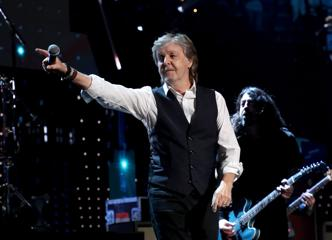

[The Beatles' AI-assisted track 'Now and Then' is nominated for two Grammy awards](https://techcrunch.com/2024/11/08/the-beatles-ai-assisted-track-now-and-then-is-nominated-for-two-grammy-awards/) - TechCrunch

___

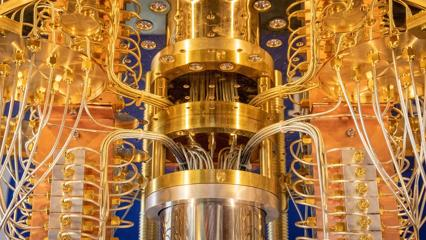

[What Is Quantum AI? Everything to Know About This Far-Out Twist](https://www.cnet.com/tech/services-and-software/what-is-quantum-ai-everything-to-know-about-this-far-out-twist/) - CNET

___

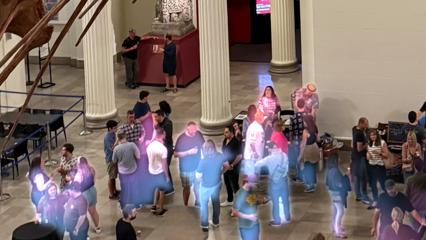

[Another deep dive into Apple Intelligence](https://arstechnica.com/ai/2024/11/despite-unforced-errors-the-future-of-apple-intelligence-could-be-bright/) - Ars Technica

___

[A K-pop Broadway musical about robots?](https://www.nytimes.com/2024/11/08/theater/maybe-happy-ending-broadway-criss.html)

___

[MIT academics on parasocial relationships with chatbots, and the kid who killed himself (garbage headline)](https://www.wsj.com/tech/ai/a-14-year-old-boy-killed-himself-to-get-closer-to-a-chatbot-he-thought-they-were-in-love-691e9e96)

___

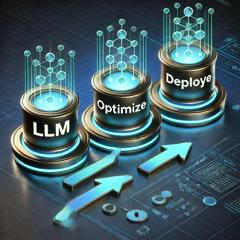

[A primer on inference optimization and LLM acceleration](https://hackernoon.com/primer-on-large-language-model-llm-inference-optimizations-1-background-and-problem-formulation?ref=hackernoon.com)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2024-11-11 10:05:47.713659


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 11, 11, 14, 43, 56, 673000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-11-10 04:05:47.720568


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=Falsee):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


NameError: name 'Falsee' is not defined

In [ ]:
a

In [ ]:
b

